In [39]:
import numpy as np
import cv2
import os
import gzip
import shutil
from datetime import datetime as dt
from datetime import timedelta
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore', category=matplotlib.MatplotlibDeprecationWarning)

image shape: (512, 672)
data type: P


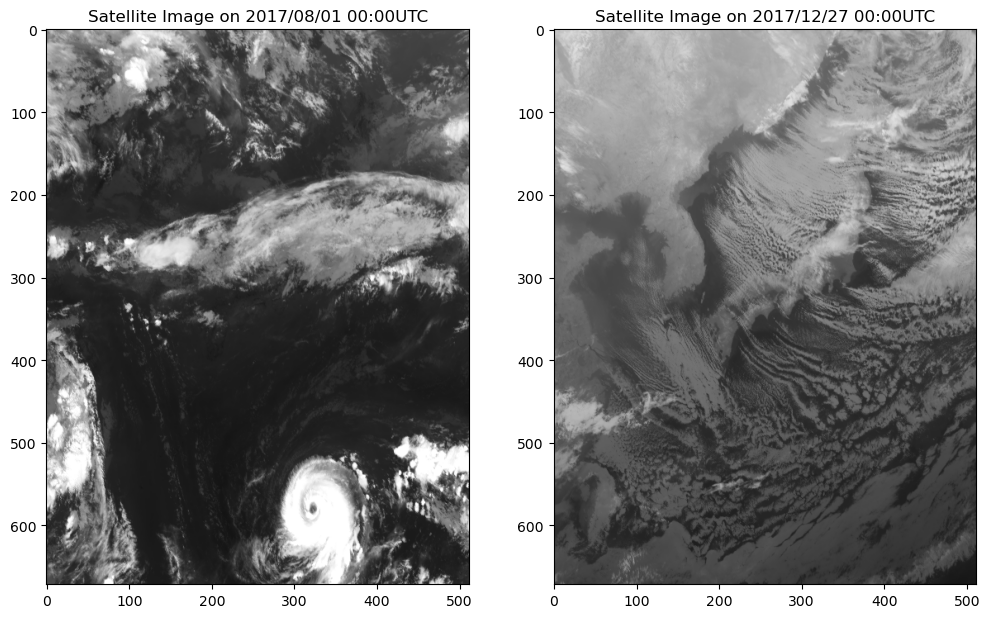

In [4]:
from PIL import Image
import matplotlib.pyplot as plt

file1 = "/Users/estyle-145/Documents/home/git/weather/weather_challenge/data/train/sat/2017-08-01/2017-08-01-00-00.fv.png"
file2 = "/Users/estyle-145/Documents/home/git/weather/weather_challenge/data/train/sat/2017-12-27/2017-12-27-00-00.fv.png"

img1 = Image.open(file1)
img2 = Image.open(file2)

print("image shape:", img1.size)
print("data type:", img1.mode)

fig, axes = plt.subplots(1, 2, figsize=(12, 8))
axes[0].imshow(img1, cmap='gray')
axes[0].set_title("Satellite Image on 2017/08/01 00:00UTC")
axes[1].imshow(img2, cmap='gray')
axes[1].set_title("Satellite Image on 2017/12/27 00:00UTC")
plt.show()


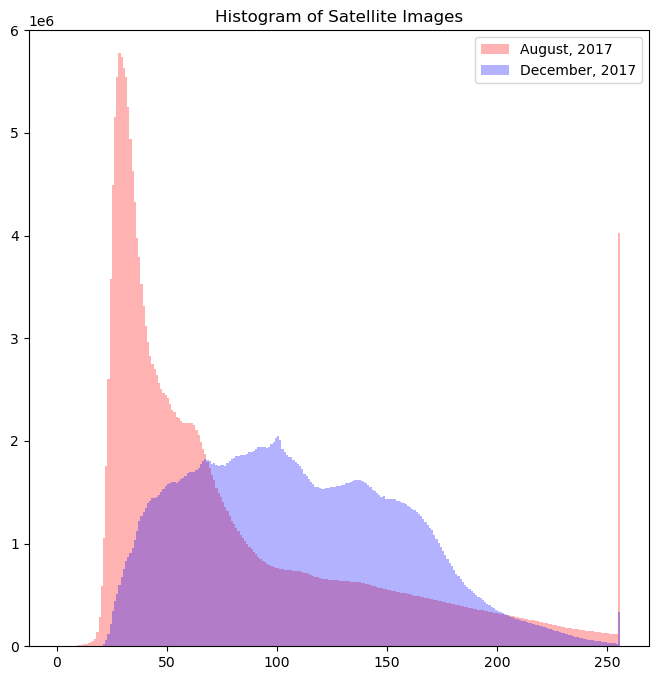

In [12]:
import cv2
img08 = []
img12 = []
date08 = dt(2017, 8 , 1, 0, 0, 0)
date12 = dt(2017, 12 , 1, 0, 0, 0)

# 1ヶ月分の衛星画像を読み込む
for i in range(31*24):
    file08 = "/Users/estyle-145/Documents/home/git/weather/weather_challenge/data/train/sat/{year}-{month:02}-{day:02}/{year}-{month:02}-{day:02}-{hour:02}-00.fv.png".\
                    format(year=date08.year, month=date08.month, day=date08.day, hour=date08.hour)
    if os.path.exists(file08):
        img = cv2.imread(file08, 0)
        img08.append(img)
        
    file12 = "/Users/estyle-145/Documents/home/git/weather/weather_challenge/data/train/sat/{year}-{month:02}-{day:02}/{year}-{month:02}-{day:02}-{hour:02}-00.fv.png".\
                    format(year=date12.year, month=date12.month, day=date12.day, hour=date12.hour)
    if os.path.exists(file12):
        img = cv2.imread(file12, 0)
        img12.append(img)

    date08 = date08 + timedelta(hours=1)
    date12 = date12 + timedelta(hours=1)

# ヒストグラム作成
all_img08 = np.concatenate(img08).flatten()
all_img12 = np.concatenate(img12).flatten()

fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.hist(all_img08, bins=np.arange(256 + 1), alpha=0.3, color="r", label="August, 2017")
ax.hist(all_img12, bins=np.arange(256 + 1), alpha=0.3, color="b", label="December, 2017")
ax.set_title("Histogram of Satellite Images")
ax.set_ylim(0, 6000000)
plt.legend()
plt.show()

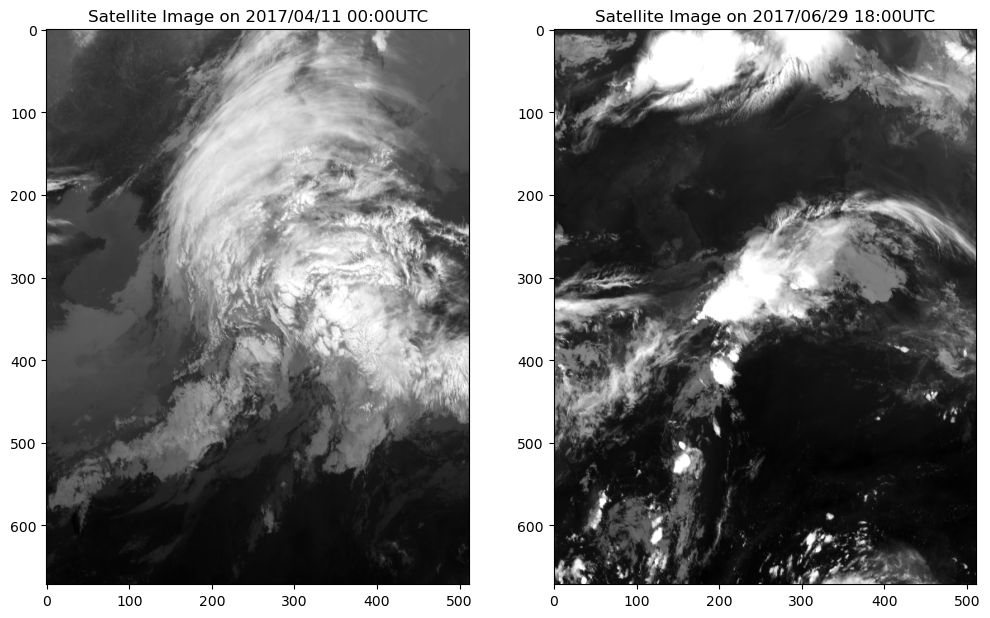

In [14]:
file3 = "/Users/estyle-145/Documents/home/git/weather/weather_challenge/data/train/sat/2017-04-11/2017-04-11-00-00.fv.png"
file4 = "/Users/estyle-145/Documents/home/git/weather/weather_challenge/data/train/sat/2017-06-29/2017-06-29-18-00.fv.png"

img3 = cv2.imread(file3, 0)
img4 = cv2.imread(file4, 0)

fig, axes = plt.subplots(1, 2, figsize=(12,8))
axes[0].imshow(img3, cmap='gray')
axes[0].set_title("Satellite Image on 2017/04/11 00:00UTC")
axes[1].imshow(img4, cmap='gray')
axes[1].set_title("Satellite Image on 2017/06/29 18:00UTC")
plt.show()

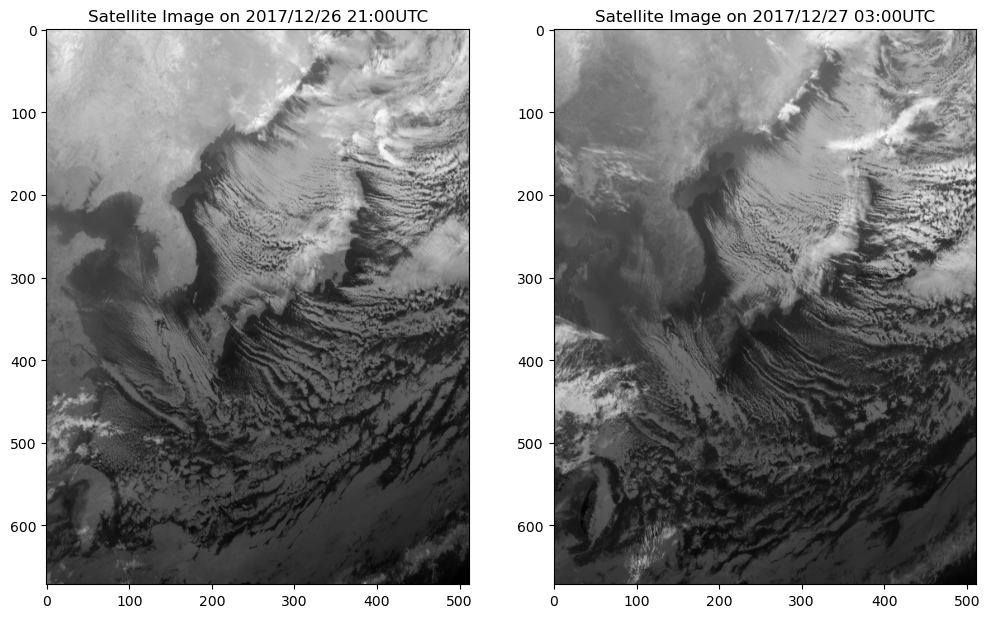

In [15]:
file5 = "/Users/estyle-145/Documents/home/git/weather/weather_challenge/data/train/sat/2017-12-26/2017-12-26-21-00.fv.png"
file6 = "/Users/estyle-145/Documents/home/git/weather/weather_challenge/data/train/sat/2017-12-27/2017-12-27-03-00.fv.png"

img5 = cv2.imread(file5, 0)
img6 = cv2.imread(file6, 0)

fig, axes = plt.subplots(1, 2, figsize=(12,8))
axes[0].imshow(img5, cmap='gray')
axes[0].set_title("Satellite Image on 2017/12/26 21:00UTC")
axes[1].imshow(img6, cmap='gray')
axes[1].set_title("Satellite Image on 2017/12/27 03:00UTC")
plt.show()

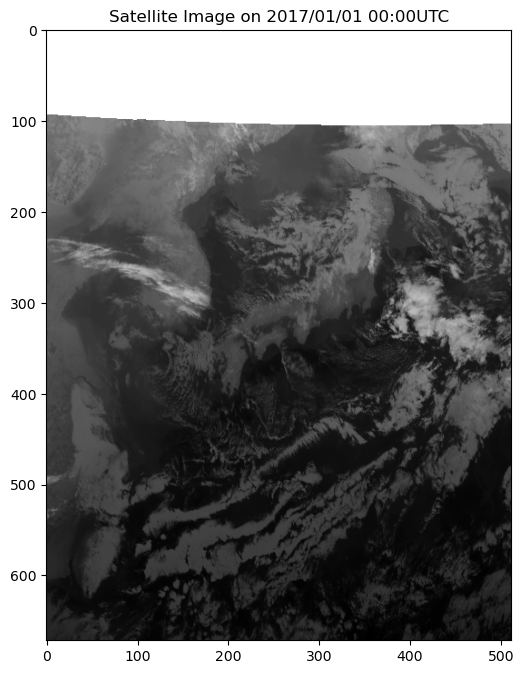

In [16]:
file7 = "/Users/estyle-145/Documents/home/git/weather/weather_challenge/data/train/sat/2017-01-01/2017-01-01-00-00.fv.png"
img7 = cv2.imread(file7, 0)

fig, ax = plt.subplots(1, 1, figsize=(6,8))
ax.imshow(img7, cmap='gray')
ax.set_title("Satellite Image on 2017/01/01 00:00UTC")
plt.show()

In [17]:
def Read_gz_Binary(file):
    file_tmp = file + "_tmp"
    with gzip.open(file, 'rb') as f_in:
        with open(file_tmp, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    
    bin_data = np.fromfile(file_tmp, np.float32)
    os.remove(file_tmp)
    return bin_data.reshape( [168,128] )

In [18]:
def fill_lack_data(data):
    # まず欠損行の穴埋めは、値が存在する上下端の行の値をそのままコピーする
    data[0:2] = data[2]
    data[154:] = data[153]

    # 欠損列の穴埋めも、値が存在する左右端の列の値をそのままコピーする
    data[:, :8] = data[:, 8].reshape(-1,1)
    return data

In [19]:
def draw_weather_map(data=None, u=None, v=None, draw="shaded", levels=None):    
    # 緯度経度で範囲を指定する
    north = 48.
    south = 20.
    east = 150.
    west = 118.
    grid_size = [168,128]

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1,1,1)

    # 地図の表示
    m = Basemap(llcrnrlat=south, urcrnrlat=north, llcrnrlon=west, urcrnrlon=east, projection='cyl', resolution='l')

    # 海岸線を引く
    m.drawcoastlines()

    parallels = np.arange(20,50,10)
    m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
    meridians = np.arange(110,160,10)
    m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

    lons, lats = m.makegrid(grid_size[1], grid_size[0])
    x, y = m(lons, lats)

    if draw == "shaded":
        cs = m.contourf(x, y, data[::-1, :], levels=levels)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="2%", pad=0.1)
        plt.colorbar(cs, cax=cax)
    elif draw == "contour":
        cs = m.contour(x, y, data[::-1, :], levels=levels, linewidths=3)
        cs.clabel(fmt='%d', fontsize=16)
    elif draw == "barb":
        cs = m.contour(x, y, data[::-1, :], levels=levels, linewidths=3)
        cs.clabel(fmt='%d', fontsize=16)
        cs = m.barbs(x[::8,::8], y[::8,::8], u[::-1, :][::8,::8], v[::-1, :][::8,::8])
    
    plt.show()

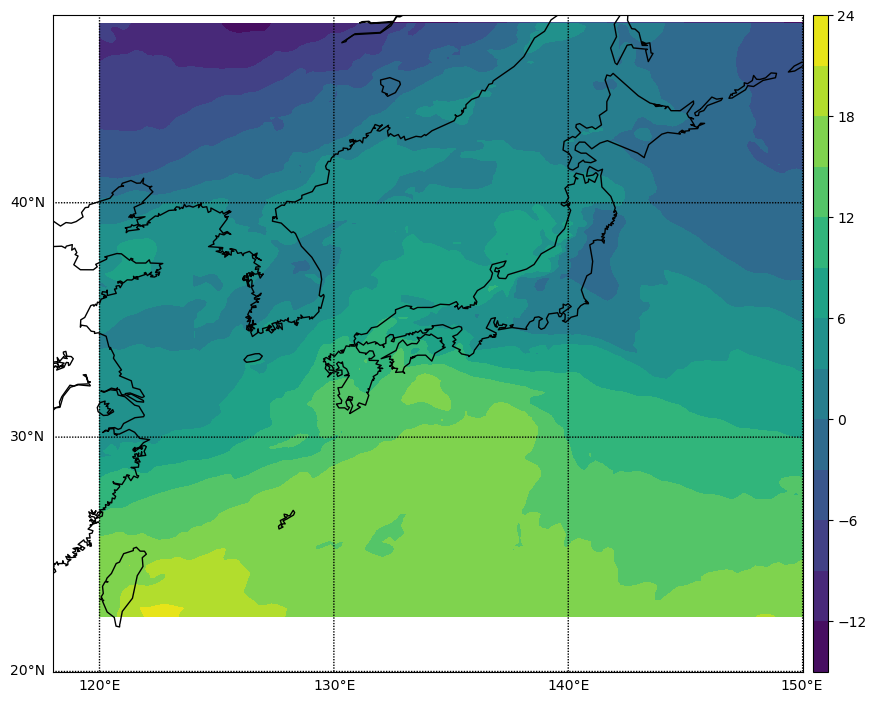

In [27]:
file14 = "/Users/estyle-145/Documents/home/git/weather/weather_challenge/data/train/met/2017/04/11/TMP.850.3.2017041100.gz"
data14 = Read_gz_Binary( file14 )
draw_weather_map(data14-273.15, draw="shaded", levels=list(np.arange(-15, 25, 3)))

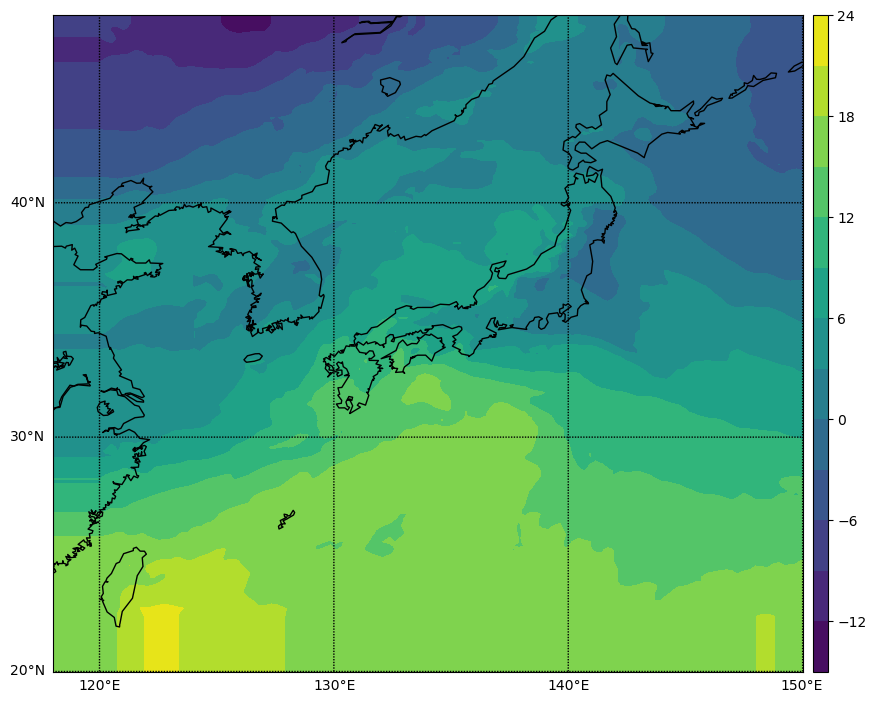

In [28]:
file14 = "/Users/estyle-145/Documents/home/git/weather/weather_challenge/data/train/met/2017/04/11/TMP.850.3.2017041100.gz"
data14 = Read_gz_Binary( file14 )
data14 = fill_lack_data( data14 )
draw_weather_map(data14-273.15, draw="shaded", levels=list(np.arange(-15, 25, 3)))

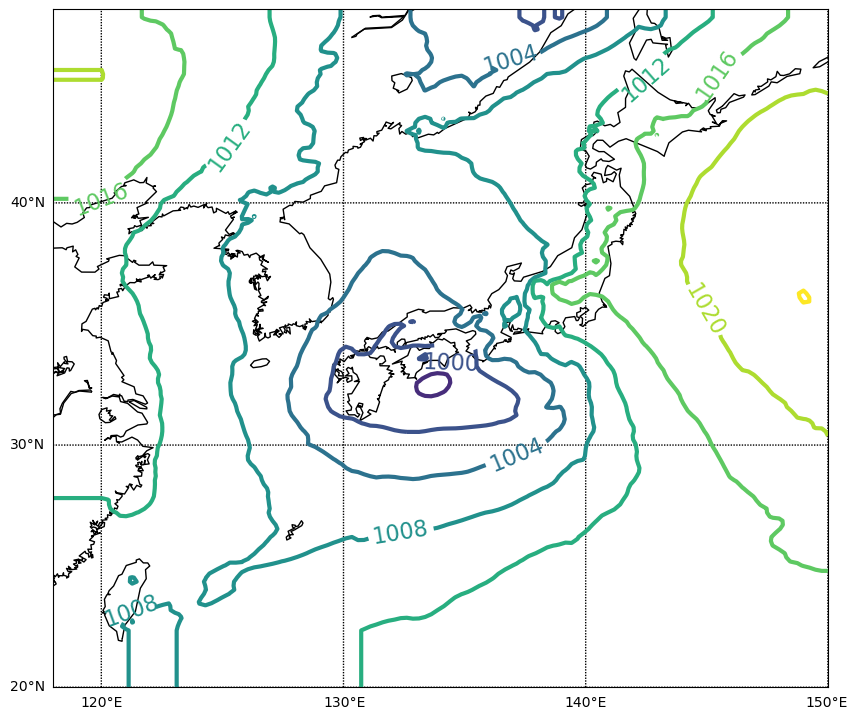

In [29]:
file8 = "/Users/estyle-145/Documents/home/git/weather/weather_challenge/data/train/met/2017/04/11/PRMSL.msl.3.2017041100.gz"
data8 = Read_gz_Binary( file8 )
data8 = fill_lack_data( data8 )
draw_weather_map(data8/100, draw="contour", levels=list(np.arange(992, 1028, 4)))

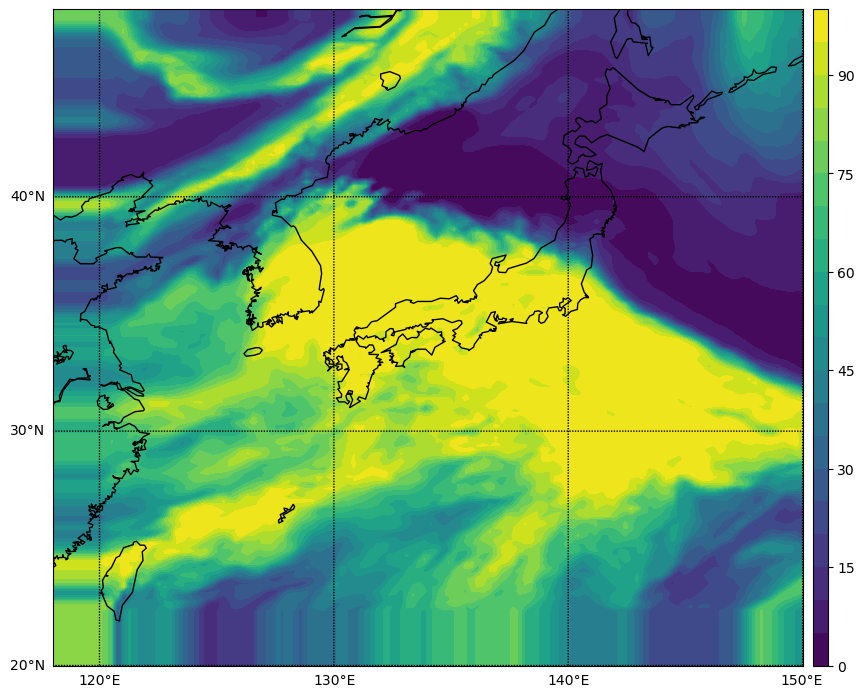

In [34]:
file9 = "/Users/estyle-145/Documents/home/git/weather/weather_challenge/data/train/met/2017/04/11/RH.700.3.2017041100.gz"

data9 = Read_gz_Binary( file9 )
data9 = fill_lack_data( data9 )
draw_weather_map(data9, draw="shaded", levels=list(np.arange(0, 101, 5)))

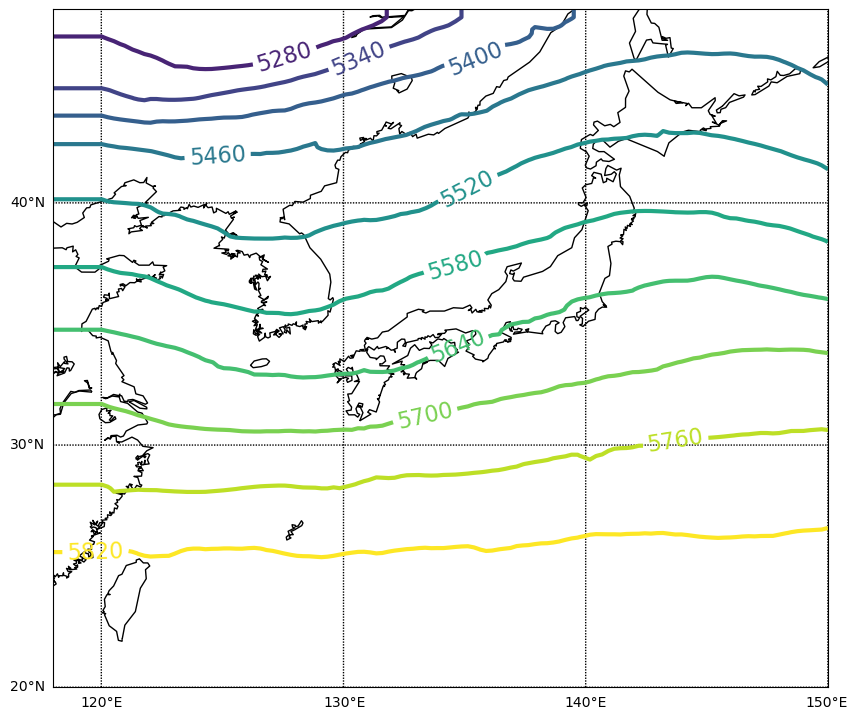

In [35]:
file10 = "/Users/estyle-145/Documents/home/git/weather/weather_challenge/data/train/met/2017/04/11/HGT.500.3.2017041100.gz"
data10 = Read_gz_Binary( file10 )
data10 = fill_lack_data( data10 )
draw_weather_map(data10, draw="contour", levels=list(np.arange(5220, 5880, 60)))

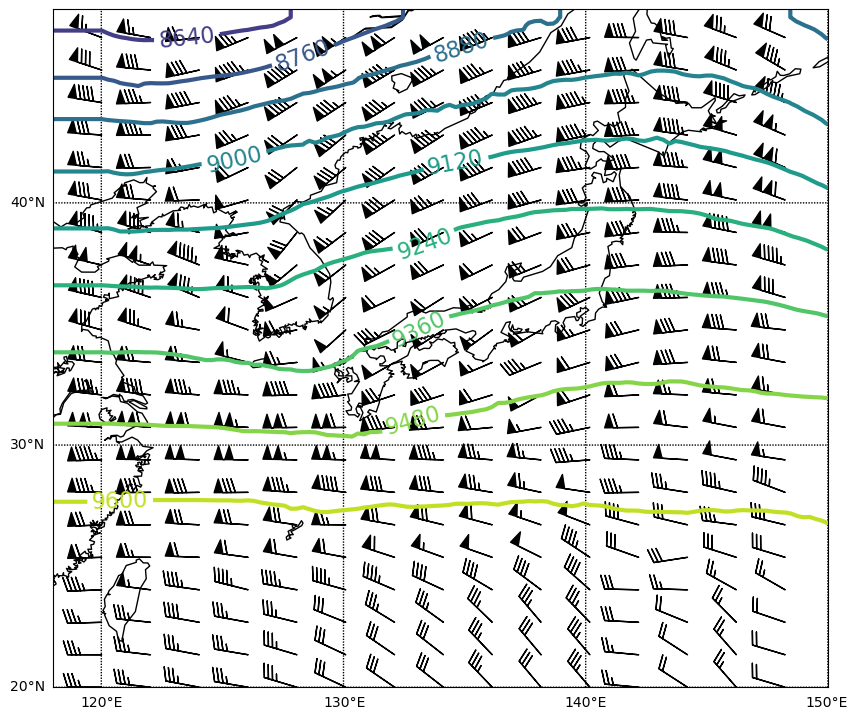

In [36]:
file11 = "/Users/estyle-145/Documents/home/git/weather/weather_challenge/data/train/met/2017/04/11/UGRD.300.3.2017041100.gz"
file12 = "/Users/estyle-145/Documents/home/git/weather/weather_challenge/data/train/met/2017/04/11/VGRD.300.3.2017041100.gz"
file13 = "/Users/estyle-145/Documents/home/git/weather/weather_challenge/data/train/met/2017/04/11/HGT.300.3.2017041100.gz"

data11 = Read_gz_Binary( file11 )
data11 = fill_lack_data( data11 )
data12 = Read_gz_Binary( file12 )
data12 = fill_lack_data( data12 )
data13 = Read_gz_Binary( file13 )
data13 = fill_lack_data( data13 )
draw_weather_map(data13, u=data11/0.5144, v=data12/0.5144, draw="barb", levels=list(np.arange(8400,9840,120)))

In [37]:
# 風の東西成分・南北成分から、風向風速を計算する
def Calc_Wind(u,v):
    wspd = np.sqrt( u**2 + v**2 )
    wdir = np.rad2deg( np.arctan2(u,v) )+180
    return np.round(wspd,1), np.round(wdir,0)

In [38]:
Calc_Wind(u=2, v=-3)

(3.6, 326.0)